Enter Current Net Asset Value (NAV):  20.3098
Enter Standard Deviation of the Mutual Fund (e.g., 0.5 for 50%):  .12
Enter Confidence Level for VaR (e.g., 0.95 for 95%):  .95
Enter Number of Monte Carlo Simulations (must be a positive integer):  8000
Enter 1-Year Annualized Return (in decimal, e.g., 8% = 0.08):  .12
Enter 3-Year Annualized Return (in decimal, e.g., 7% = 0.07):  .15
Enter 5-Year Annualized Return (in decimal, e.g., 6% = 0.06):  .13



--- Monte Carlo Simulation Results ---

Normal Market Scenario:
Value at Risk (VaR): 1.21 (NAV: 19.10)
Tail Risk: 1.71 (Average NAV: 18.60)
Expected Return: 3.78%
Expected NAV: 21.08

Bull Market Scenario:
Value at Risk (VaR): 1.03 (NAV: 19.28)
Tail Risk: 1.55 (Average NAV: 18.76)
Expected Return: 4.68%
Expected NAV: 21.26

Bear Market Scenario:
Value at Risk (VaR): 1.58 (NAV: 18.73)
Tail Risk: 2.11 (Average NAV: 18.20)
Expected Return: 2.09%
Expected NAV: 20.73


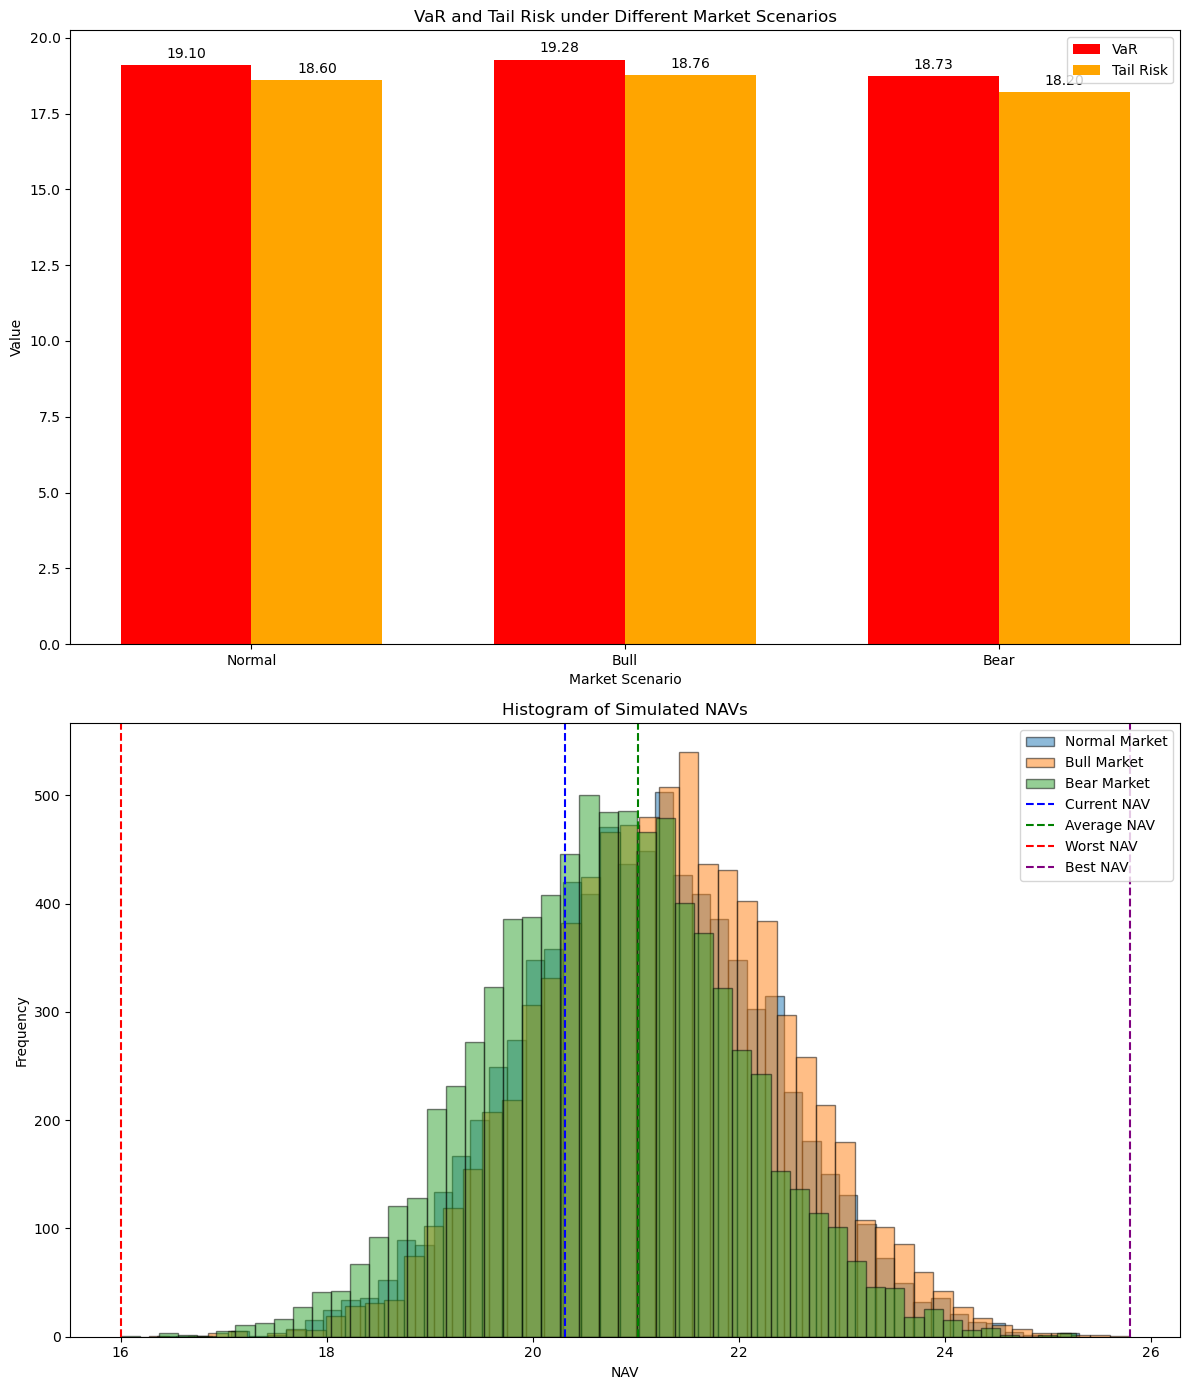

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_user_input():
    while True:
        try:
            nav = float(input("Enter Current Net Asset Value (NAV): "))
            std_dev = float(input("Enter Standard Deviation of the Mutual Fund (e.g., 0.5 for 50%): "))
            if std_dev <= 0:
                print("Standard Deviation must be greater than 0.")
                continue
            confidence_level = float(input("Enter Confidence Level for VaR (e.g., 0.95 for 95%): "))
            if confidence_level <= 0 or confidence_level >= 1:
                print("Confidence Level must be between 0 and 1.")
                continue
            num_simulations = int(input("Enter Number of Monte Carlo Simulations (must be a positive integer): "))
            if num_simulations <= 0:
                print("Number of Simulations must be a positive integer.")
                continue
            one_year_return = float(input("Enter 1-Year Annualized Return (in decimal, e.g., 8% = 0.08): "))
            three_year_return = float(input("Enter 3-Year Annualized Return (in decimal, e.g., 7% = 0.07): "))
            five_year_return = float(input("Enter 5-Year Annualized Return (in decimal, e.g., 6% = 0.06): "))
            return {
                'nav': nav,
                'std_dev': std_dev / np.sqrt(4),  # Quarterly standard deviation adjusted for 63 trading days
                'confidence_level': confidence_level,
                'num_simulations': num_simulations,
                'one_year_return': one_year_return / 4,  # Quarterly return adjusted for 63 trading days
                'three_year_return': three_year_return / 4,  # Quarterly return adjusted for 63 trading days
                'five_year_return': five_year_return / 4  # Quarterly return adjusted for 63 trading days
            }
        except ValueError:
            print("Invalid input. Please ensure all inputs are of the correct type (e.g., numbers for numeric inputs).")

def monte_carlo_simulation(nav, std_dev, confidence_level, num_simulations, 
                           one_year_return, three_year_return, five_year_return):
    market_conditions = {
        'Normal': three_year_return,
        'Bull': (one_year_return + three_year_return) / 2 + 0.05 / 4,  
        'Bear': (five_year_return - 0.05 / 4)  
    }

    results = {}
    simulated_navs = {}
    for market, mean_return in market_conditions.items():
        simulated_returns = np.random.normal(mean_return, std_dev, num_simulations)
        future_navs = nav * (1 + simulated_returns)
        simulated_navs[market] = future_navs
        
        future_navs.sort()
        var_index = int((1 - confidence_level) * num_simulations)
        var = future_navs[var_index]
        tail_risk_avg = np.mean(future_navs[:var_index])
        expected_return = np.mean(simulated_returns)
        expected_nav = nav * (1 + expected_return)
        
        results[market] = {
            'Value at Risk (VaR)': f"{nav - var:.2f} (NAV: {var:.2f})",
            'Tail Risk': f"{nav - tail_risk_avg:.2f} (Average NAV: {tail_risk_avg:.2f})",
            'Expected Return': f"{expected_return * 100:.2f}%",
            'Expected NAV': f"{expected_nav:.2f}"
        }
    
    return results, simulated_navs

def plot_simulations(simulated_navs, nav, results):
    """
    Plots the simulated NAVs and a comparison of VaR, Tail Risk, and Expected NAV.
    """
    fig, axs = plt.subplots(2, figsize=(12, 14))
    
    # Combined bar graph of Value at Risk (VaR) and Tail Risk
    var_values = {market: nav - float(result['Value at Risk (VaR)'].split(' ')[0]) for market, result in results.items()}
    tail_risk_values = {market: nav - float(result['Tail Risk'].split(' ')[0]) for market, result in results.items()}
    markets = var_values.keys()
    
    x = np.arange(len(markets))  # Label locations
    width = 0.35  # Width of the bars

    bars1 = axs[0].bar(x - width/2, var_values.values(), width, label='VaR', color='red')
    bars2 = axs[0].bar(x + width/2, tail_risk_values.values(), width, label='Tail Risk', color='orange')

    axs[0].set_xlabel('Market Scenario')
    axs[0].set_ylabel('Value')
    axs[0].set_title('VaR and Tail Risk under Different Market Scenarios')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(markets)
    axs[0].legend()

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            axs[0].annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    add_labels(bars1)
    add_labels(bars2)

    # Histogram for Expected NAV
    for market, navs in simulated_navs.items():
        axs[1].hist(navs, bins=50, alpha=0.5, label=f'{market} Market', edgecolor='black')
    
    # Calculate overall statistics
    all_navs = np.concatenate(list(simulated_navs.values()))
    avg_nav = np.mean(all_navs)
    worst_nav = np.min(all_navs)
    best_nav = np.max(all_navs)
    expected_nav_values = [float(result['Expected NAV']) for result in results.values()]

    axs[1].axvline(nav, color='blue', linestyle='--', label='Current NAV')
    axs[1].axvline(avg_nav, color='green', linestyle='--', label='Average NAV')
    axs[1].axvline(worst_nav, color='red', linestyle='--', label='Worst NAV')
    axs[1].axvline(best_nav, color='purple', linestyle='--', label='Best NAV')
    axs[1].set_xlabel('NAV')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Simulated NAVs')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def main():
    user_inputs = get_user_input()
    results, simulated_navs = monte_carlo_simulation(**user_inputs)
    
    print("\n--- Monte Carlo Simulation Results ---")
    for market, metrics in results.items():
        print(f"\n{market} Market Scenario:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")
    
    plot_simulations(simulated_navs, user_inputs['nav'], results)

if __name__ == "__main__":
    main()